# Categorisez automatiquement des questions - Nettoyage

In [2]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [CARACTERISTIQUES](#CARACTERISTIQUES)
* [NETTOYAGE](#NETTOYAGE)
    * [Tokenisation](#Tokenisation)
    * [Nettoyage des stopwords](#Nettoyage-des-stopwords)
    * [Lemmatisation](#Lemmatisation)
* [SAUVEGARDE](#SAUVEGARDE)

# PREPARATION

## Import des librairies

In [3]:
import time

import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import joblib

import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /Users/hui-guan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/hui-
[nltk_data]     guan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hui-guan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /Users/hui-
[nltk_data]     guan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Paramétrage du notebook

In [4]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [5]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=120
pd.options.display.min_rows=100

## Declaration des fonctions

In [6]:
#%run /Users/hui-guan/Documents/Developpement/Jupyter/Lib/outilsEDA.py

def profil(df):
    """
    Fonction qui retourne le profil des données d'un dataframe (moyenne, ecart type, min, max, valeurs manquantes, valeurs uniques)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données

    Returns
    -------
    result : DataFrame
        un DataFrame de profil, contenant un résumé statistique des données
    """
    
    dfValeursManquantes=pd.concat([df.isna().sum(),100*df.isna().sum()/len(df)],axis=1,keys=["missing_values","%_missing_values"])
    dfTypes=pd.DataFrame({'type':df.dtypes})
    result=df.describe(include='all',datetime_is_numeric=True).T
    result=result.merge(dfTypes,left_index=True,right_index=True)
    result=result.merge(dfValeursManquantes,left_index=True,right_index=True)
    return result
def summarizeFrequenciesDf(df,threshold):
    """
    Fonction mode qui agrege les variables qui sont sous un seuil 'threshold'(pour les très gros dataframe qui ont du mal à plotter)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données
    threshold: Int
        seuil au dessous duquel le comptage des observations sont agrégées dans la catégorie 'autres'

    Returns
    -------
    result : DataFrame
        un DataFrame contenant le comptage des observations au dessus du seuil et tout le reste dans la catégorie 'Autres'
    """

    dfFrequencies=df.value_counts()
    dfNormalizedFrequencies=df.value_counts(normalize=True) # frequence normalisée des valeurs de chaque variable
    mask = dfNormalizedFrequencies>threshold # masque sur les fréquences > seuil
    dfTail= dfFrequencies.loc[~mask].sum()
    dfFrequencies=dfFrequencies.loc[mask] # filtre sur les fréquences < seuil
    dfFrequencies['Autres']=dfTail # ajout des fréquences > seuil agregées dans la categorie 'Autre'
    return pd.DataFrame(dfFrequencies)
def plotCategoricalDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables categorielles d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures

    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCategorical=df.select_dtypes(include=['object','string', 'category'])
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))

    # Titre
    fig.suptitle("Distribution Variables Categorielles", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)
    
    i=0
    for x in dfCategorical.columns:
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)
        
        # On classe dans la categorie "Autres" les variables sous le seuil de 0,5% de frequence d'observation,
        dfCurrent=summarizeFrequenciesDf(dfCategorical[x],0.005)
    
        axes[i].bar(dfCurrent[x].index,dfCurrent[x],color='#ee6352')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#3fa7d6')
    
        i=i+1
    plt.show()
        
def plotQuantitativeDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])
    dfQSkew=dfQuantitative.skew(skipna = True).to_frame('SKEW')
    dfQColumnsSorted=dfQSkew.sort_values(by='SKEW',ascending=False).T.columns #tri des colonnes par valeur de skew

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))
    
    # Titre
    fig.suptitle("Distribution Variables Quantitatives", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)
    
    dfQuantitative
    i=0
    for x in dfQColumnsSorted:
        #dfCurrent=dfNumerical[x].sample(1000,replace=True).sort_index() #optimisation pour les large datasets
        dfCurrent=dfQuantitative[x].dropna(axis=0)
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)    
        
        axes[i].hist(dfCurrent,color='#3fa7d6')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#ee6352')
    
        i=i+1
    plt.show()
def plotCorrelationHeatmap(plt,df):
    """
    Fonction affiche la heatmap des correlation d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCorr=df.corr()
    plt.rcParams["figure.figsize"] = (10,10)
    plt.matshow(dfCorr,cmap='coolwarm',interpolation='nearest')
    plt.xticks(range(len(dfCorr.columns)), dfCorr.columns, size='small',rotation='vertical');
    plt.yticks(range(len(dfCorr.columns)), dfCorr.columns, size='small');
    plt.show()
    
def plotBoxes(plt,df,nrows,ncols):
    """
    Fonction affiche les boites à moustache des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage
    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,20))
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)


    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    i=0
    for x in dfQuantitative.columns:
            axes[i].boxplot(dfQuantitative[x].dropna())
            axes[i].set_title(x,color='#3fa7d6')
            i+=1
    plt.show()

def tokenize(text):
    tokens=re.findall(r'\w{2,}', text)
    return tokens
# On remarque que la lemmatisation de base n'est pas tout à fait correcte: 
# Parce que "are" n'est pas converti en "to be" et "hanging" n'est pas converti en "hang" comme attendu. 
# Cela peut être corrigé si nous fournissons la balise "part of speech" correcte (balise POS) comme deuxième argument de lemmatize()
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token,get_wordnet_pos(token)) for token in tokens]
    return lemmas

# CHARGEMENT

In [7]:
# Calculate the time elapsed in seconds
start = time.time()

In [8]:
%%time
#df=pd.read_csv("drive/MyDrive/Colab Notebooks/Datasets/stackoverfllow_qa.csv")
df=pd.read_csv("../Dataset/stackoverfllow_qa.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     50000 non-null  int64  
 1   PostTypeId             50000 non-null  int64  
 2   AcceptedAnswerId       29765 non-null  float64
 3   ParentId               0 non-null      float64
 4   CreationDate           50000 non-null  object 
 5   DeletionDate           0 non-null      float64
 6   Score                  50000 non-null  int64  
 7   ViewCount              50000 non-null  int64  
 8   Body                   50000 non-null  object 
 9   OwnerUserId            49047 non-null  float64
 10  OwnerDisplayName       2786 non-null   object 
 11  LastEditorUserId       27684 non-null  float64
 12  LastEditorDisplayName  1531 non-null   object 
 13  LastEditDate           28133 non-null  object 
 14  LastActivityDate       50000 non-null  object 
 15  Ti

In [9]:
pd.set_option("display.max_columns",23)
df.sample(5)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
11116,52130806,1,NaN,NaN,2018-09-01 17:58:55,NaN,-3,71,"<p>I want to create dynamic number of columns based on some condition given in R:</p>\n\n<p>Say,I've a dataframe cal...",9999850.0,NaN,6326565.0,NaN,2018-09-02 14:44:07,2018-09-02 14:44:07,How to create specific number of columns dynamically based on a condition given a column in R,<r><dataframe>,1,1,NaN,NaN,NaN,CC BY-SA 4.0
44054,62820834,1,63740881.0,NaN,2020-07-09 17:53:08,NaN,2,1968,<p>I am running into below error during terraform apply.</p>\n<pre><code>Error: timeout while waiting for plugin to ...,12368716.0,NaN,1839482.0,NaN,2020-07-09 18:36:40,2020-09-04 12:05:46,"Terraform apply throwing Error ""timeout while waiting for plugin to start""",<kubernetes><terraform><terraform-provider-aws><iaas><terraform0.12+>,1,3,NaN,NaN,NaN,CC BY-SA 4.0
34879,3403629,1,3403744.0,NaN,2010-08-04 07:58:08,NaN,3,912,<p>I am generating an automatically generated periodical report with Sweave. In order to create a nice header I use ...,366256.0,NaN,3885376.0,NaN,2017-10-29 19:56:59,2017-10-29 19:56:59,How to use Sweave (R) code inside a fancyhdr?,<r><latex><sweave>,2,0,NaN,NaN,NaN,CC BY-SA 3.0
43463,54154888,1,54155223.0,NaN,2019-01-11 22:28:49,NaN,-2,42,"<p>Whenever I run this I got something like ' 196875307' as the total, could \nsomeone tell me whats wrong with it.H...",10850719.0,NaN,10850719.0,NaN,2019-01-11 22:47:18,2019-01-11 23:09:30,Can someone explain me whats wrong with finding total part in this code,<c>,2,1,NaN,NaN,NaN,CC BY-SA 4.0
27023,3385820,1,3385844.0,NaN,2010-08-02 07:31:12,NaN,0,15188,"<p>HI,</p>\n\n<p>I'm having a JSON parsed return object set.</p>\n\n<pre><code>{\n ""word"":[\n ""offered"",\n ...",403255.0,NaN,21234.0,NaN,2010-08-02 07:31:47,2012-08-03 08:43:30,JSON - Find the length of objects,<javascript><json>,2,0,2.0,NaN,NaN,CC BY-SA 2.5


# CARACTERISTIQUES

In [10]:
dfProfil=profil(df)
dfProfil[["missing_values","%_missing_values"]]

,missing_values,%_missing_values
Id,0,0.000
PostTypeId,0,0.000
AcceptedAnswerId,20235,40.470
ParentId,50000,100.000
CreationDate,0,0.000
DeletionDate,50000,100.000
Score,0,0.000
ViewCount,0,0.000
Body,0,0.000
OwnerUserId,953,1.906


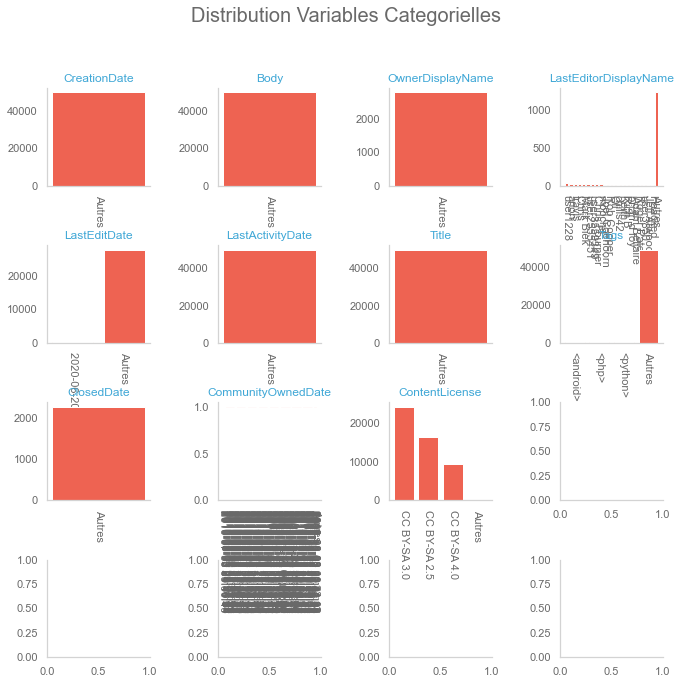

In [61]:
plotCategoricalDistributions(plt,df,4,4,10,10)

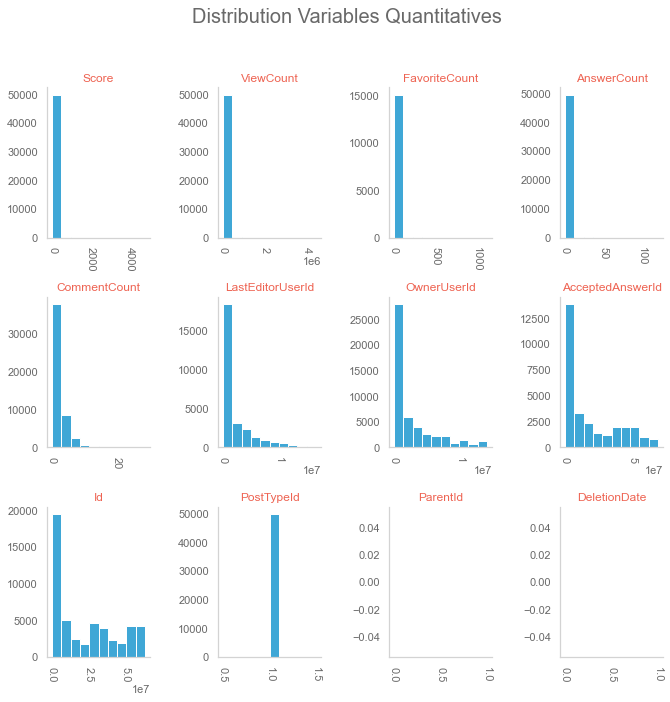

In [62]:
plotQuantitativeDistributions(plt,df,3,4,10,10)

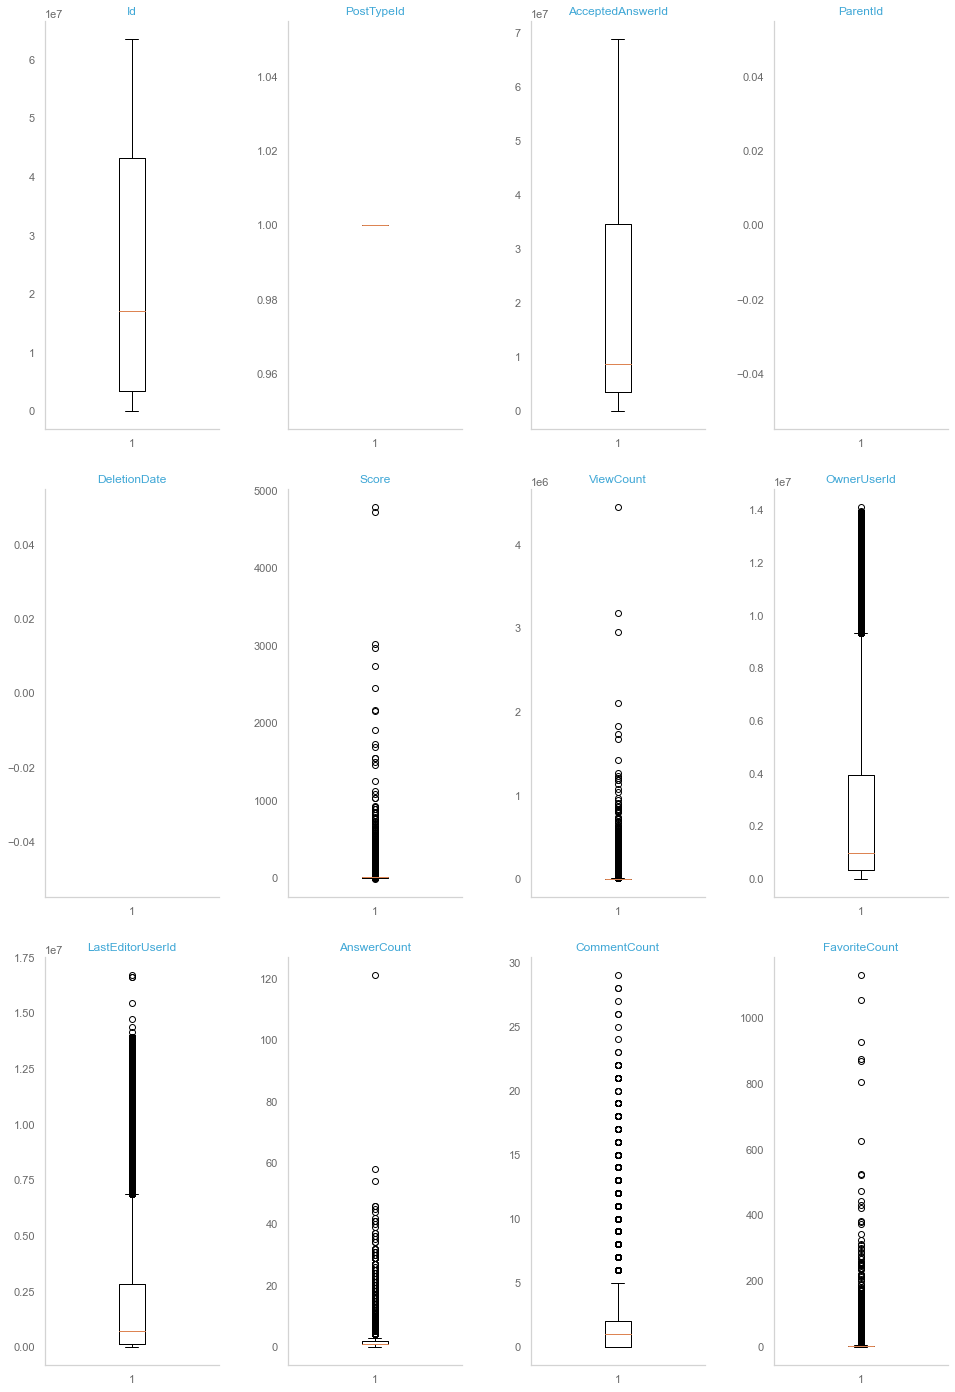

In [63]:
plotBoxes(plt,df,3,4)

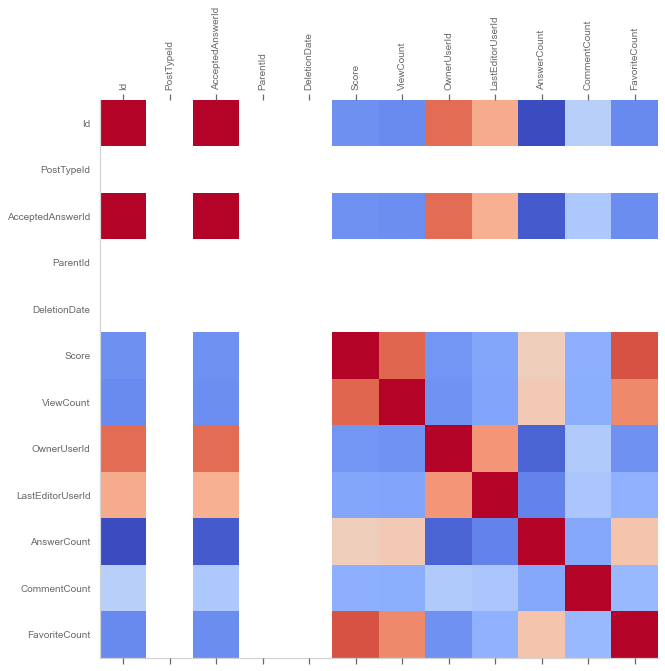

In [64]:
plotCorrelationHeatmap(plt,df)

Pour catégoriser les questions, nous utiliserons les colonnes title, body et tag car ces colonnes contiennent du texte et n'ont pas de valeurs manquantes.  
Les colonnes OwnerDisplayName et LastEditorDisplayName auraient pu être intéressantes mais elles ont toutes les deux plus de 94% de valeurs manquantes.  
Nous ne les garderons donc pas.

# NETTOYAGE

In [65]:
# on ne garde que les colonnes contenant du texte
dfCleaned=df[['Title','Body','Tags']]

# uniformisation du dataframe en minuscule
dfCleaned=dfCleaned.astype(str).apply(lambda x: x.str.lower())
# aperçu des données
dfCleaned.head(5)

,Title,Body,Tags
0,comprehensive image processing example using cocoa api,<p>can someone point out a comprehensive example on image processing using cocoa api? i am developing an application...,<cocoa><image-processing>
1,testing gps in iphone simulator problem,<p>i found some various articles about testing the gps (corelocation) in the iphone simulator. \nit seems pretty str...,<iphone><gps><core-location>
2,create pdf inapp ios,"<blockquote>\n <p><strong>possible duplicate:</strong><br>\n <a href=""https://stackoverflow.com/questions/1360912/...",<ios><pdf><pdf-generation>
3,flex 4 stopping an embbeded swf,"<p>i have this flex 4.1 script:</p>\n\n<pre><code>&lt;fx:script&gt;\n &lt;![cdata[\n [embed(source=""res/sw...",<apache-flex><actionscript-3>
4,html form - firing the form submit using the enter key does not work when focus is on a select list,"<p>i'm stuck on the above problem. i have a simple form as follows, with a text input, a select list and a submit bu...",<html><forms><submit>


In [66]:
# Titre: suppression des caracteres speciaux et ponctuations
dfCleaned['CleanedTitle']=dfCleaned['Title'].replace('["!\"#$%&\(\)\*\+-\.\/:;<=>\?\@\\^_`\{\|\}~\n"]',' ',regex=True).astype(str)

# Corps: suppression des balises html, \n,;,//,date ou chiffres,chaine contenant le caractere _, ponctuations  dans le Body
dfCleaned['CleanedBody']=dfCleaned['Body'].replace('(<\/?[a-z]+>|&lt;|&gt;|//|["!\"#$%&\(\)\*\+-\.\/:;<=>\?\@\\^_\'`\{\|\}~\n"]|\d+.\d+|\S+_\S+|\*+|[0-9]+[a-z]+|[\d+]|[abcd]{2,}[a-z]*)', ' ',regex=True).astype(str)
#suppression des blancs superflus
dfCleaned['CleanedBody']=dfCleaned['CleanedBody'].str.strip()

# suppression des <,>  dans les Tags
dfCleaned['Tags']=dfCleaned['Tags'].replace('[<>]', ' ',regex=True).astype(str)

## Nettoyage des stopwords

In [67]:
%%time
#  suppression des stopwords dans le body, alimente la colonne FilteredBody
stop_words = set(stopwords.words('english'))

filteredBody=[]
for i in range(len(dfCleaned['CleanedBody'])):
    filteredBody.append(' '.join([word for word in re.split(r"\W+", dfCleaned['CleanedBody'][i]) if word not in stop_words]))
dfCleaned['FilteredBody']=filteredBody

filteredTitle=[]
for i in range(len(dfCleaned['CleanedTitle'])):
    filteredTitle.append(' '.join([word for word in re.split(r"\W+", dfCleaned['CleanedTitle'][i]) if word not in stop_words]))
dfCleaned['FilteredTitle']=filteredTitle

CPU times: user 3.42 s, sys: 16.9 ms, total: 3.44 s
Wall time: 3.44 s


In [68]:
del dfCleaned['CleanedBody']
del dfCleaned['CleanedTitle']

In [69]:
dfCleaned.sample(10)

,Title,Body,Tags,FilteredBody,FilteredTitle
526,entity class from database....error invalid resource _pm,<p>i have created a database and table in mysql through phpmyadmin. i am trying to connect this to my project using ...,mysql jdbc netbeans entity,created mysql phpmy trying connect project using entity class however get following error run project com sun appser...,entity class database error invalid resource pm
48647,"formatting using decimalformat throws exception - ""cannot format given object as a number""",<p>this might look like a repeated question but i tried in all the below links and can't get a proper answer.</p>\n\...,java exception overloading illegalargumentexception decimalformat,might look like repeated question tried links get proper answer href https st com questions format given object numb...,formatting using decimalformat throws exception cannot format given object number
32283,jsf links not working on facelets,<p>i have created a jsf 2 page which uses facelets to define the structure of the page.</p>\n\n<pre><code>&lt;div cl...,jsf jakarta-ee jsf-2 facelets,created jsf page uses f define structure page div class page div class content ui insert name content ui insert div ...,jsf links working facelets
8080,angularjs - ng-disabled doesn't work as expected,"<p>i am trying to disable file <code>input</code> tag, after user selected a file.</p>\n\n<p>html:</p>\n\n<pre><code...",javascript html angularjs,trying dis file input tag user selected file html div ng controller firstcontroller div ng controller secon input ty...,angularjs ng disabled work expected
12463,split string delimited by comma without respect to commas in brackets,"<p>i've got a string like</p>\n\n<pre><code>s=""abc, 3rncd (23uh, sdfuh), 32h(q23q)89 (as), dwe8h, edt (1,wer,345,rtz...",java regex string split,got string like sdfuh q dwe edt wer rtz tr nope want split string string parts sdfuh q dwe edt wer rtz tr nope simpl...,split string delimited comma without respect commas brackets
43886,nant merge task not executing,<p>i have a nant merge task aimed at a nunit test output.xml i have installed the relevant xsl transform files and ...,.net cruisecontrol.net nant,nant merge task aimed nunit test output xml installed relevant xsl transform files menu option show see nunit detail...,nant merge task executing
40164,delphi rtti get property - why does this results in av?,<p>i am trying to write a spec utility library.</p>\n\n<p>one of the specification is a texpressionspecification. ba...,delphi generics rtti,trying write spec utility library one specifi texpressionspecifi implements specifi pattern evaluating inner texpres...,delphi rtti get property results av
10440,arduino - about data types,<p>i am writing a delay function for arduino to be used in a project. the reason is that timer0 (the default timer u...,c++ arduino-uno,writing delay function arduino used project reason timer default timer used arduino delay pwm control test code dela...,arduino data types
10531,is there any blog plugin which i can use with my existing rails3 application?,<p>i need to add a blog to my existing rails application. i am looking for a such blog-plugin which also give me abi...,ruby-on-rails ruby-on-rails-3 plugins,need blog existing rails appli looking blog plugin also give tagging blogs seo friendly urls kind plugin gem avail c...,blog plugin use existing rails3 application
4052,update some chrome extension files from own server,<p>i am writing a chrome extension in which some script and an xml file in which i data is to be read by the script ...,google-chrome-extension auto-update,writing chrome extension script xml file script changed almost twice per include link every page lo hosting server l...,update chrome extension files server


## Tokenisation

In [70]:
%%time

# conversion du corpus de chaque document en tokens unique
dfCleaned['BodyTokens']=dfCleaned['FilteredBody'].map(tokenize)

CPU times: user 1.35 s, sys: 130 ms, total: 1.48 s
Wall time: 1.48 s


In [71]:
dfCleaned['TitleTokens']=dfCleaned['FilteredTitle'].map(tokenize)

In [72]:
dfCleaned.sample(8)

,Title,Body,Tags,FilteredBody,FilteredTitle,BodyTokens,TitleTokens
30057,swap arrays by using pointers in c++,"<p>i have two arrays of pointers to doubles that i need to swap. rather than just copy the data within the arrays, i...",c++ arrays pointers swap,two arrays pointers doubles need swap rather copy within arrays would efficient swap pointers arrays always impressi...,swap arrays using pointers c,"[two, arrays, pointers, doubles, need, swap, rather, copy, within, arrays, would, efficient, swap, pointers, arrays,...","[swap, arrays, using, pointers]"
17182,heroku 409 error when python dash app calls api,"<p>starting process with command from procfile works.</p>\n\n<p>then as soon as it starts reading the python file, a...",python api heroku server plotly-dash,starting process command procfile works soon starts python file pulling api get error exception worker process tr ra...,heroku 409 error python dash app calls api,"[starting, process, command, procfile, works, soon, starts, python, file, pulling, api, get, error, exception, worke...","[heroku, 409, error, python, dash, app, calls, api]"
5076,set a usercontrol property to not show up in vs properties window,<p>i have a usercontrol in my asp.net project that has a public property. i do not want this property to show up in ...,c# asp.net visual-studio properties attributes,usercontrol asp net project public property want property show visual studio property window user highlights instanc...,set usercontrol property show vs properties window,"[usercontrol, asp, net, project, public, property, want, property, show, visual, studio, property, window, user, hig...","[set, usercontrol, property, show, vs, properties, window]"
12878,"how can we define one-to-one, one-to-many, many-to-one, and many-to-many lstm neural networks in keras?","<p>i am reading <a href=""http://karpathy.github.io/2015/05/21/rnn-effectiveness/"" rel=""noreferrer"">this</a> article ...",python neural-network keras lstm recurrent-neural-network,href http karpathy github io rnn effectiveness rel noreferrer article unreason effectiveness recurrent neural networ...,define one one one many many one many many lstm neural networks keras,"[href, http, karpathy, github, io, rnn, effectiveness, rel, noreferrer, article, unreason, effectiveness, recurrent,...","[define, one, one, one, many, many, one, many, many, lstm, neural, networks, keras]"
27534,is it necessary to upgrade to jquery 1.4?,<p>i have been using jquery 1.23 till now and nowadays most of the plugins are being developed for the 1.4 version. ...,jquery,using jquery till plugins developed version want know necessary upgr jquery mean modules right still work,necessary upgrade jquery 1 4,"[using, jquery, till, plugins, developed, version, want, know, necessary, upgr, jquery, mean, modules, right, still,...","[necessary, upgrade, jquery]"
21290,making a class behave like a bunch of keyword arguments in python,<p>so i have a class that will have a lot of attributes. is there a way to make this class behave in a way that i ca...,python,class lot attributes way make class behave way pass kwarg function class foo object def self self self b b foo foo s...,making class behave like bunch keyword arguments python,"[class, lot, attributes, way, make, class, behave, way, pass, kwarg, function, class, foo, object, def, self, self, ...","[making, class, behave, like, bunch, keyword, arguments, python]"
33326,output gzipped result as a stream,<p>i have a simple php script that output a sitemap from a list of urls. </p>\n\n<p>the sitemap is generated on the ...,php gzip,simple php script output sitemap list urls sitemap generated fly far output xml directly works think compressed xml ...,output gzipped result stream,"[simple, php, script, output, sitemap, list, urls, sitemap, generated, fly, far, output, xml, directly, works, think...","[output, gzipped, result, stream]"
45971,java.lang.classcastexception: org.jboss.ws.core.soap.textimpl cannot be cast to javax.xml.s

## Lemmatisation

In [73]:
%%time
dfCleaned['BodyLemmas']=dfCleaned['BodyTokens'].map(lemmatize)

CPU times: user 8min 20s, sys: 1min 14s, total: 9min 35s
Wall time: 9min 36s


In [74]:
%%time
dfCleaned['TitleLemmas']=dfCleaned['TitleTokens'].map(lemmatize)

CPU times: user 31.4 s, sys: 4.62 s, total: 36.1 s
Wall time: 36.1 s


In [75]:
def highlight_cols(s):
    color = 'lightgrey'
    return 'background-color: %s' % color

In [82]:
dfCleaned.sample(3).style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['Title', 'Body','Tags']])

,Title,Body,Tags,FilteredBody,FilteredTitle,BodyTokens,TitleTokens,BodyLemmas,TitleLemmas
45583,"wordpress > create category as child of ""uncategorized"" (catid=1)","i've got a script in my functions.php file that checks for the existence of several categories that are required by my theme, and if they are not present, it creates them... if(!get_cat_id('my-category')){wp_create_category('my-category');} i need to modify this script in two ways... first, i need to create the category so that its parent category is the ""uncategorized"" category (or id 1). second, if the category already exists, but its parent is not id 1, i need to make it so.",wordpress categories,got script functions php file checks existence several required theme present creates need modify script two ways first need create parent un id second alre exists parent id need make,wordpress create category child uncategorized catid 1,"['got', 'script', 'functions', 'php', 'file', 'checks', 'existence', 'several', 'required', 'theme', 'present', 'creates', 'need', 'modify', 'script', 'two', 'ways', 'first', 'need', 'create', 'parent', 'un', 'id', 'second', 'alre', 'exists', 'parent', 'id', 'need', 'make']","['wordpress', 'create', 'category', 'child', 'uncategorized', 'catid']","['get', 'script', 'function', 'php', 'file', 'check', 'existence', 'several', 'require', 'theme', 'present', 'creates', 'need', 'modify', 'script', 'two', 'way', 'first', 'need', 'create', 'parent', 'un', 'id', 'second', 'alre', 'exists', 'parent', 'id', 'need', 'make']","['wordpress', 'create', 'category', 'child', 'uncategorized', 'catid']"
23834,how to reshape matlab matrices for this example?,i have a 40x16 matrix or 8 5x16 one below the other i.e. aligned vertically. i want to get a 5x128 matrix from that such that i align the 8 5x16 matrices horizontally. is there an efficient/quicker (rather than the hardcoded for loops) way to do this? i want the individual 5x16 matrices intact.,matlab matrix reshape,matrix x one e aligned verti want get matrix align x matrices horizontally efficient quicker rather har loops way want individual matrices int,reshape matlab matrices example,"['matrix', 'one', 'aligned', 'verti', 'want', 'get', 'matrix', 'align', 'matrices', 'horizontally', 'efficient', 'quicker', 'rather', 'har', 'loops', 'way', 'want', 'individual', 'matrices', 'int']","['reshape', 'matlab', 'matrices', 'example']","['matrix', 'one', 'align', 'verti', 'want', 'get', 'matrix', 'align', 'matrix', 'horizontally', 'efficient', 'quicker', 'rather', 'har', 'loop', 'way', 'want', 'individual', 'matrix', 'int']","['reshape', 'matlab', 'matrix', 'example']"
24110,regex syntax validator,"does anybody know any tool for validating the syntax of an regular expression? i dont want to validate if it matches or not with some text but i want to see if there are syntax errors in the regex (missing parenthisis etc). also, what about syntax highlighting? it would be a great help when writing complex regex.",regex syntax highlighting validation,anybody know tool vali syntax regular expression dont want vali matches text want see syntax errors regex missing parenthisis etc also syntax highlighting would great help writing complex regex,regex syntax validator,"['anybody', 'know', 'tool', 'vali', 'syntax', 'regular', 'expression', 'dont', 'want', 'vali', 'matches', 'text', 'want', 'see', 'syntax', 'errors', 'regex', 'missing', 'parenthisis', 'etc', 'also', 'syntax', 'highlighting', 'would', 'great', 'help', 'writing', 'complex', 'regex']","['regex', 'syntax', 'validator']","['anybody', 'know', 'tool', 'vali', 'syntax', 'regular', 'expression', 'dont', 'want', 'vali', 'match', 'text', 'want', 'see', 'syntax', 'error', 'regex', 'miss', 'parenthisis', 'etc', 'also', 'syntax', 'highlight', 'would', 'great', 'help', 'write', 'complex', 'regex']","['regex', 'syntax', 'validator']"


In [77]:
dfCleaned.sample(3)

,Title,Body,Tags,FilteredBody,FilteredTitle,BodyTokens,TitleTokens,BodyLemmas,TitleLemmas
14013,add custom field inside a do_shortcode,"<p>i'm trying to add a contact form into a page template with contact form 7. however, i want the destination email ...",php wordpress advanced-custom-fields shortcode contact-form-7,trying cont form page template cont form however want destination email come custom field created code pulls custom ...,add custom field inside shortcode,"[trying, cont, form, page, template, cont, form, however, want, destination, email, come, custom, field, created, co...","[add, custom, field, inside, shortcode]","[try, cont, form, page, template, cont, form, however, want, destination, email, come, custom, field, create, code, ...","[add, custom, field, inside, shortcode]"
46753,(some function) is not defined with sympy lambdify,"<p>so i'm writing a script that evaluates taylor series. however, i want it to evaluate for all types of functions. ...",python numpy sympy,writing script evaluates taylor series however want evaluate types functions tried example using function x x sy sym...,function defined sympy lambdify,"[writing, script, evaluates, taylor, series, however, want, evaluate, types, functions, tried, example, using, funct...","[function, defined, sympy, lambdify]","[write, script, evaluates, taylor, series, however, want, evaluate, type, function, try, example, use, function, sy,...","[function, define, sympy, lambdify]"
48067,how can i pass parameters to a jquery $.getjson callback method?,<p>i'm trying to use jquery to call some custom api via <code>ajax/$.getjson</code>. </p>\n\n<p>i'm trying to pass a...,javascript jquery callback,trying use jquery custom api via ajax getjson trying pass custom value ajax method value getting passed getting over...,pass parameters jquery getjson callback method,"[trying, use, jquery, custom, api, via, ajax, getjson, trying, pass, custom, value, ajax, method, value, getting, pa...","[pass, parameters, jquery, getjson, callback, method]","[try, use, jquery, custom, api, via, ajax, getjson, try, pas, custom, value, ajax, method, value, get, pass, get, ov...","[pas, parameter, jquery, getjson, callback, method]"


# SAUVEGARDE

In [25]:
dfCleaned.drop(['FilteredBody','FilteredTitle','BodyTokens','TitleTokens'], axis=1, inplace=True)

In [26]:
joblib.dump(dfCleaned.sample(5000),'dfCleaned5000.jbl.bz2')

['dfCleaned5000.jbl.bz2']

In [27]:
joblib.dump(dfCleaned,'dfCleaned.jbl.bz2')

#joblib.dump(dfCleaned,"drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")

['dfCleaned.jbl.bz2']

In [28]:
elapsed=time.time() - start
elapsed

678.3514068126678